In [ ]:
! unzip Project2_data.zip 

              0        1         2    ...       236      237       238
-1.9819  -3.16860 -2.28180 -0.114000  ...  0.372030  1.02440  0.066127
-2.2841  -3.03210 -1.63080  0.813850  ...  0.447020  0.81992 -0.346520
-0.92302 -1.94690 -2.24080 -1.788600  ...  0.188380  0.67484  0.235640
-1.1349  -2.44400 -2.77380 -2.007400  ...  0.157540  0.70737  0.249680
-0.61764 -1.19280 -1.59820 -1.732400  ...  0.126170  0.32200  0.003727
...           ...      ...       ...  ...       ...      ...       ...
-1.2633  -2.04430 -1.36650  0.276040  ...  0.164030  0.57248  0.030455
-0.31307 -0.66733 -0.52892  0.087866  ...  0.075487  0.24226  0.118350
-0.104   -0.81115 -1.10820 -0.690720  ...  0.039384  0.38334  0.405340
-0.82542 -0.52062  0.22913  0.829580  ...  0.105870 -0.10956 -0.560040
-0.52942 -0.63330 -0.19738  0.325200  ...  0.092607  0.21487 -0.067697

[94 rows x 239 columns]
   -1.9819  -2.2841  -0.92302  -1.1349  ...  -0.31307   -0.104  -0.82542  -0.52942
0  -3.1686 -3.03210 -1.946900 -2.44400  

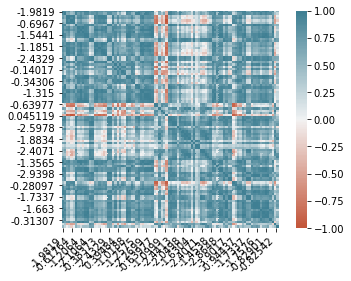

In [67]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
data_dir = os.path.join("Project2_data","Train")
file="train_sample100.csv"
df = pd.read_csv(os.path.join(data_dir,file)).T
# s = df['A']
print(df)
# print(s)
index=0
data=df.iloc[:, index:index+10].T
print(data)
corr= data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [68]:
window = 10
stride = 10
def load_fmri(data_dir=None):
    if data_dir == None:
        data_dir = os.path.join("Project2_data","Train")
    
    # The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation

    window = 10
    stride = 10
    # inputs = []# np.zeros()
    labels = [] # np.zeros()
    
    
    inputs = np.zeros((1, 23, 8836))
    labels = np.zeros((1,1),dtype=int)

    for file in tqdm_notebook(os.listdir(data_dir)): 
        # each file --> (corrM series, label)
        df = pd.read_csv(os.path.join(data_dir,file)).T
        corrM_sequence =  np.array([])
        index = 0
        while index <= len(df.columns)-window: #--- slice across columns
              data=df.iloc[:, index:index+window].T # 10 datapoints at a time
              corrM = data.corr().to_numpy().reshape((1,94*94)) #shape=(1,2)
              if corrM_sequence.size == 0:
                  corrM_sequence = np.copy(corrM)
              else:
                  corrM_sequence = np.concatenate((corrM_sequence, corrM), axis=0)
              index += stride          
        file_label = int(file[12:].replace(".csv", ""))
        if file_label <= 144:
            # labels.append(1)
            labels = np.concatenate((labels, [[int(1)]]), axis=0)
        else:
            labels = np.concatenate((labels, [[int(0)]]), axis=0)

        if inputs.size == 0:
            inputs = np.copy(corrM_sequence)
        else:
            # print("Inputshape " + str(inputs.shape))
            # print("Seqshape " + str(corrM_sequence.shape))
            inputs = np.concatenate((inputs, [corrM_sequence]), axis=0)
    # --------------------- Split data into train/test portions and combining all data from different files into a single array --------------------------------
    test_portion = int(0.05*len(inputs))
    print("Length input "+ str(len(inputs))+ " and test portion "+ str(test_portion))
    train_x, train_y = inputs[:-test_portion], labels[:-test_portion]
    test_x, test_y = inputs[-test_portion:], labels[-test_portion:]
    return train_x, train_y, test_x, test_y
#-===============================================================================================
train_x, train_y, test_x, test_y = load_fmri()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Length input 247 and test portion 12


In [69]:
print(train_x.shape)
print(train_y.shape)
# train_y

(235, 23, 8836)
(235, 1)


In [70]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 20

train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
dataset_size = len(train_dataset)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - val_size
train_data, val_data = random_split(train_dataset, [train_size,val_size])

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [71]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [72]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return self.sigmoid(out), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [73]:
# next(iter(train_loader))[0].shape
print(train_x.shape)
print(train_y.shape)
print(next(iter(train_loader))[0].shape[2])
# train_y

(235, 23, 8836)
(235, 1)
8836


In [78]:
loss_list = []
epoch_list = []
acc_list = [] 
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=500, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    print(input_dim)
    output_dim = 2
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            # print(out.squeeze().shape)
            # print(label.squeeze().shape)
            loss = criterion(out.squeeze(), label.squeeze().to(device).long())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
        loss_list.append(avg_loss/len(train_loader))
        epoch_list.append(epoch)
        acc_list.append(cal_accuracy(model,val_loader))   
        if epoch%10 == 0:
            print("Epoch {}/{} Done: Total Loss: {:.4f}. Accuracy {}".format(epoch, EPOCHS, avg_loss/len(train_loader), cal_accuracy(model,val_loader)))        
    return model

In [79]:
def cal_accuracy(model, dataloader):
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for sequences, labels in dataloader:
        # print(sequences.shape)
        h = model.init_hidden(sequences.shape[0])
        outputs,h = model(sequences.to(device).float(), h)
        indices, pre = torch.max(outputs.data, 1)
        predicted = torch.argmax(outputs.data, dim=1)
        # print("indeces are " + str(indices))
        # print("Argmax are " + str(torch.argmax(outputs.data, dim=1)))
        # print("Labels " + str(labels.squeeze()))
        # Total number of labels
        total += labels.size(0)
          
        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.squeeze().cpu()).sum()
        else:
            correct += (predicted == labels.squeeze()).sum()
      
    accuracy = 100 * correct / total
    # Print Loss
    # print('Accuracy: {}'.format(accuracy))
    return accuracy 

# cal_accuracy(gru_model,val_loader) 

In [80]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

8836
Starting Training of GRU model
Epoch 10/500 Done: Total Loss: 0.3426. Accuracy 65.0
Epoch 20/500 Done: Total Loss: 0.3478. Accuracy 75.0
Epoch 30/500 Done: Total Loss: 0.3243. Accuracy 75.0
Epoch 40/500 Done: Total Loss: 0.3150. Accuracy 65.0
Epoch 50/500 Done: Total Loss: 0.3305. Accuracy 70.0
Epoch 60/500 Done: Total Loss: 0.3319. Accuracy 75.0
Epoch 70/500 Done: Total Loss: 0.3243. Accuracy 55.0
Epoch 80/500 Done: Total Loss: 0.3209. Accuracy 65.0
Epoch 90/500 Done: Total Loss: 0.3211. Accuracy 60.0
Epoch 100/500 Done: Total Loss: 0.3139. Accuracy 75.0
Epoch 110/500 Done: Total Loss: 0.3135. Accuracy 75.0
Epoch 120/500 Done: Total Loss: 0.3135. Accuracy 75.0
Epoch 130/500 Done: Total Loss: 0.3535. Accuracy 65.0
Epoch 140/500 Done: Total Loss: 0.3314. Accuracy 75.0
Epoch 150/500 Done: Total Loss: 0.3761. Accuracy 70.0
Epoch 160/500 Done: Total Loss: 0.3356. Accuracy 70.0
Epoch 170/500 Done: Total Loss: 0.3472. Accuracy 70.0
Epoch 180/500 Done: Total Loss: 0.3313. Accuracy 60.0
E

Text(0.5, 1.0, 'Loss w.r.t. epochs')

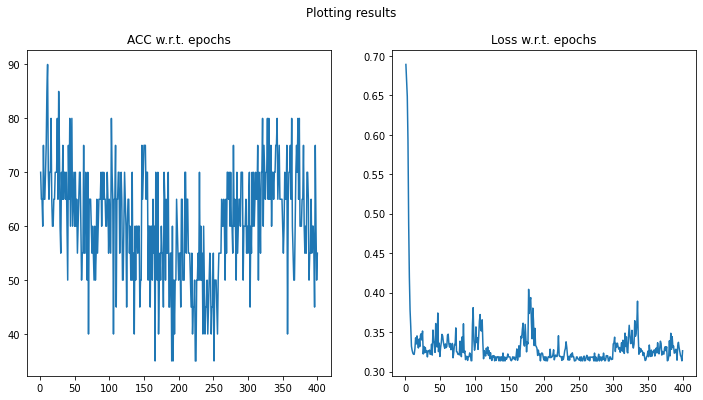

In [77]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Plotting results')
epoch = np.asarray(epoch_list)
ACC = np.asarray(acc_list)
ax1.plot(epoch, ACC)
ax1.set_title('ACC w.r.t. epochs')

loss = np.asarray(loss_list)
ax2.plot(epoch, loss)
ax2.set_title('Loss w.r.t. epochs')


In [81]:
def load_test_fmri(data_dir=None,model=None):
    if data_dir == None:
        data_dir = os.path.join("Project2_data","Test")

    window = 10
    stride = 10
    # inputs = []# np.zeros() 
    
    inputs = np.zeros((1, 23, 8836))
    labels = np.zeros((1,1),dtype=int)

    
    for file in tqdm_notebook(os.listdir(data_dir)): 
        # each file --> (corrM series, label)
        df = pd.read_csv(os.path.join(data_dir,file)).T
        corrM_sequence =  np.array([])
        index = 0
        while index <= len(df.columns)-window: #--- slice across columns
              data=df.iloc[:, index:index+window].T # 10 datapoints at a time
              corrM = data.corr().to_numpy().reshape((1,94*94)) #shape=(1,2)
              if corrM_sequence.size == 0:
                  corrM_sequence = np.copy(corrM)
              else:
                  corrM_sequence = np.concatenate((corrM_sequence, corrM), axis=0)
              index += stride          
        
        file_label = int(file[11:].replace(".csv", ""))
        labels = np.concatenate((labels, [[int(file_label)]]), axis=0)

        if inputs.size == 0:
            inputs = np.copy(corrM_sequence)
        else:
            inputs = np.concatenate((inputs, [corrM_sequence]), axis=0)
    print("Length input "+ str(len(inputs[0])))
    return inputs, labels

test_prediction, file_labels = load_test_fmri()
print(test_prediction.shape)
print(file_labels.shape)

batch_size = 5
test_fmri_dataset = TensorDataset(torch.from_numpy(test_prediction),torch.from_numpy(file_labels))
dataset_size = len(test_fmri_dataset)
print(dataset_size)
test_fmri_loader = DataLoader(test_fmri_dataset, shuffle=False, batch_size=batch_size,drop_last=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



Length input 23
(21, 23, 8836)
(21, 1)
21


In [82]:
def predict_fmri_test(model, dataloader):
    # Calculate Accuracy         
    correct = 0
    total = 0
    predicted = None
    labels = None
    # Iterate through test dataset
    for sequences, file_label in dataloader:
        h = model.init_hidden(sequences.shape[0])
        outputs,h = model(sequences.to(device).float(), h)
        indices, pre = torch.max(outputs.data, 1)
        if predicted == None:
            predicted = torch.argmax(outputs.data, dim=1)
            labels = file_labels.squeeze()
        else:
            predicted = torch.cat((predicted,torch.argmax(outputs.data, dim=1)), 0)
    print("P"+ str(predicted))
    print("Labels "+str(labels))
    return predicted, labels

pred = predict_fmri_test(gru_model,test_fmri_loader)

Ptensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
Labels [ 0  5 20  7 12  6  1  3 11  4 10 19  9 16 14 13  8 17 18 15  2]
